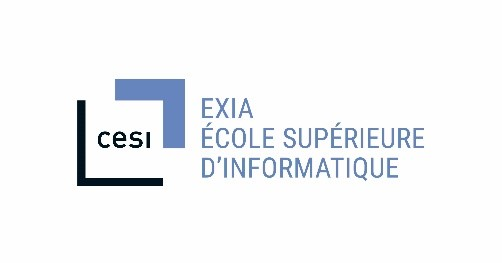


# **Livrable 02 - Traitement d'images (PHASE 2)**

#### **Membre de groupe**

*   Djaffer Zinedine Ait Rabah
*   Soltane Benghezal
*   Fares Mounir Merzouk
*   Ghada Messaour

####  **Chef de groupe** 

*   Abdelhamid Larachi

#### **Pilote de Formation : Mr. Fayçal Khetar**
#### **Pilote de l'option : Mr. Hani Haroun Afrit**
---

# **Description du livrable**

L'objectif de ce livrable consiste à creer un model capable de traiter le bruit présent dans les images. Grâce à des operations de convolution enchainées qui formeront notre autoencodeur, nous allons pouvoir éliminer le bruit. Nous avons fait le choix du Réseau de neuronnes convolutifs (CNN) pour des raisons de performmance et d'efficacité.

Voici ce qui est attendu pour ce livrable :

* Le code de chargement du fichier.

* Le code du débruitage sur un sous-ensemble d'images bruitées. Le code doit être accompagné d'explications.

* Une étude de cas.


### Description du modèle recherchée

Type d'apprentissage : `Non Supervisé` <br />
Type de traitement : `Débruitage` <br />
Type de modèle : `Auto-encodeurs`

### Description des données

Nous avons un dossier contenant **150 photos RGB**.

## 1. Configuration de l'environnement

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras
import skimage
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Conv2D, UpSampling2D, BatchNormalization
import cv2 
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import os 
import random
from keras.models import Model
from keras import regularizers
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
%matplotlib inline

Pour atteindre notre objectif, nous allons utiliser le dataset fourni pour faire le traitement d'images :

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
EPOCHS = 100
BATCH_SIZE = 32
DATASET = r'C:\Users\FoxHound\AI\noisy_dataset'

## 2. Chargement des données en mémoire

In [ ]:
def create_dataset(path):
    img_data_array=[]
    
    for file in os.listdir(path):
        try:
            image_path= os.path.join(path,  file)
            image= cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            image= cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            image= np.array(image)
            image= image.astype('float32')
            image /= 255
            if(len(image.shape)==3):
                img_data_array.append(image)
        except Exception as e:
            print("bad image :" + image_path)
            #print(str(e))
    return np.array(img_data_array) # extract the image array

data = create_dataset(DATASET)

## 3. Création des jeux de données

Maintenant que notre jeu de données est importé, nous allons le diviser en deux parties :

- **Jeu d'entrainement** : 80% des données
- **Jeu de test** : 20% des données

Nous allons à présent diviser notre dataset en deux lots : 

- **Le train_set** : qui servira à entrainer le model.
- **Le test_set**  : qui servira à valider le model.

In [ ]:
print(len(data), "images.")
x_train = data[:120] #80%
x_test = data[120:150] #20%

150 images.


Quelque images :

In [ ]:
def printImg(lst, n):
    plt.figure(figsize=(20, 2))
    for i in range(1,n):
        ax = plt.subplot(1, n, i)
        plt.imshow(lst[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

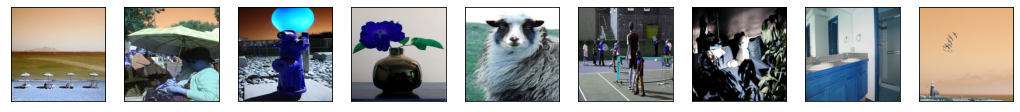

In [ ]:
printImg(x_test, 10)

## 4. Bruitage des photos

En photographie, le bruit est un défaut qui se caractérise par des grains plus ou moins nombreux sur une image, réduisant sa qualité et rendre son exploitation impossible. Il existe différents types de bruits mais celui qui nous interessera est le [bruit numérique](https://blog.photo24.fr/bruit-numerique-quest-ce-que-cest/).

Le bruit numérique que nous allons appliquer est le bruit gaussien, qui est particulièrement important car il est très répandu. Il est caractérisé par une fonction de densité de probabilité qui suit la courbe en cloche (ou fonction gaussienne).

![title](https://i.ibb.co/BTWbymP/BBBB.png)

# II. Ajout de bruit dans les images

Afin d'approuver notre modèle, nous allons d'abord devoir générer des bruits sur les données d'entrée de notre modèle. Pour ce faire, nous allons utiliser un filtre gaussien.

### A propos des filtres gaussiens
---
**Filtre gaussien**

Comme son nom l'indique, le filtre gaussien possède un noyau de convolution de forme gaussienne.
Le filtre de Gauss est, en électronique et en traitement du signal, un filtre dont la réponse impulsionnelle est une fonction gaussienne. Le filtre de Gauss minimise les temps de montée et de descente, tout en assurant l'absence de dépassement en réponse à un échelon. Cette propriété est étroitement liée au fait que le filtre de Gauss présente un retard de groupe minimal.

En mathématiques, le filtre de Gauss modifie le signal entrant par une convolution avec une fonction gaussienne.

Les propriétés de réduction de bruit des filtres Gaussiens peuvent être utilisées en combinaisons avec d'autres filtres qui, au contraire, générent du bruit. On peut par exemple choisir d'appliquer d'abord un filtre Gaussien pour réduire le bruit, avant d'appliquer un filtre x pour détecter les points autour desquels les variations de luminosité sont importantes.


In [ ]:
def gaussian_noise(x_train,x_test,sigma):
    row,col,ch= x_train[0].shape
    
    x_train_noisy = skimage.util.random_noise(x_train, mode='gaussian', seed=None, clip=True, mean=0, var=sigma**2)
    x_test_noisy = skimage.util.random_noise(x_test, mode='gaussian', seed=None, clip=True, mean=0, var=sigma**2)

    x_train_noisy = np.clip(x_train_noisy, 0., 1.)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    
    return x_train_noisy,x_test_noisy

In [ ]:
x_train_noisy,x_test_noisy = gaussian_noise(x_train,x_test,0.5)

Ci-dessous les images du dataset aprés avoir ajouté le bruit :

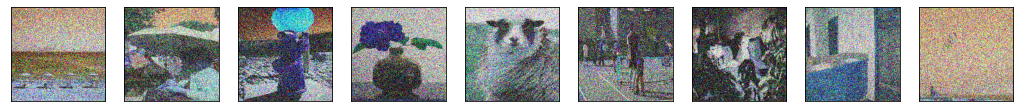

In [ ]:
printImg(x_test_noisy, 10)

# 5. Construction du modèle 

Nous allons maintenant construire un auto-encodeur de réduction du bruit. Avec un auto-encodeur, il est possible de supprimer les grains de bruit des images afin de voir clairement les principaux objets ou pour un pre-processing avant d'appliquer un auto-encodeur de classification par exemple. Pour cela, il faut créer un modèle d'auto-encodeur convolutif composé de :

*  encodeur composé de trois couches convolutives
*  décodeur composé de l'inverse des couches de l'encodeur.
### **Description des couches**

---


*   **Conv2D** : Keras Conv2D est une couche de convolution 2D, cette couche crée un noyau de convolution qui est le vent avec des couches d'entrée qui aident à produire un tenseur de sorties.

*   **MaxPooling2D** : Maxpooling est une opération de regroupement qui sélectionne l'élément maximal dans la région de la carte des caractéristiques couverte par le filtre. Ainsi, la sortie après la couche max-pooling serait une carte de caractéristiques contenant les caractéristiques les plus importantes de la carte de caractéristiques précédente.


*   **UpSamling2D** : Répète les lignes et les colonnes des données par size[0]et size[1]respectivement.autrement dit, c'est une couche simple sans poids qui doublera les dimensions de l'entrée et peut être utilisée dans un modèle génératif lorsqu'elle est suivie d'une couche convolutive traditionnelle.

### **Rappel:  Encodeur - Décodeur - Autoencodeur**


---


*   **Encodeur** : C'est un circuit combinatoire qui convertit les informations binaires sous la forme de 2N lignes d'entrée en N lignes de sortie qui représentent N code binaire pour l 'entrée.


*   **Décodeur** : Un décodeur est aussi un circuit combinatoire en tant que codeur mais son fonctionnement est exactement inverse de celui du codeur. Un décodeur est un appareil qui génère le signal original en sortie du signal d'entrée codé et convertit n lignes d'entrée en 2n lignes de sortie.

*   **Autoencodeur** : La procédure d'autoencodeur de débruitage a été inventée pour aider : les couches cachées de l'autoencodeur apprennent des filtres plus robustes. Réduisez le risque de surapprentissage dans l'encodeur automatique. Empêcher l'autoencodeur d'apprendre une fonction d'identification simple.

### **Rappel:  Fonction de perte - Optimiseur Adam**


---




*   **Fonction de perte:**
La fonction de perte que nous utilisons pour entraîner l'autoencodeur dépend fortement du type d'entrée et de sortie auquel nous voulons que l'autoencodeur s'adapte. Si nous travaillons avec des données d'image, les fonctions de perte les plus populaires pour la reconstruction sont la perte MSE.

*   **Optimiseur Adam:** 
Adam est un algorithme d'optimisation de remplacement pour la descente de gradient stochastique pour la formation de modèles d'apprentissage en profondeur. Adam combine les meilleures propriétés des algorithmes AdaGrad et RMSProp pour fournir un algorithme d'optimisation capable de gérer des gradients clairsemés sur des problèmes bruyants.





![Image](https://p3-juejin.byteimg.com/tos-cn-i-k3u1fbpfcp/b841006d264c48c18f6b50db52e9b13a~tplv-k3u1fbpfcp-watermark.image)


In [8]:
input_img = Input(shape=x_train[0].shape)

#encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

#decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Ici, nous allons définir l'optimiseur et la perte pour notre réseau de neurones
# Le MSE ou Mean squared error (MSE) est une mesure de la qualité d'un estimateur - il est toujours non négatif, et les valeurs proches de zéro sont meilleures.

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        1849

### Auto-Encodeur convolutif

L'Auto-Encodeur convolutif est composé de blocs convolutifs et utilise la réduction/augmentation de dimension pour reconstituer l'entrée. Puisque nos entrées sont des images, il est logique d'utiliser des réseaux de neurones convolutionnels. Dans la pratique, les auto-codeurs appliqués aux images sont toujours des auto-codeurs convolutifs de par leur performance.

Notre modèle sera composé de cette manière :
- **Encodeur** : `Quatre blocs convolutifs composés de 16, 32, 64 et 128 couches` ainsi que trois fonctions MaxPooling afin de réduire la dimension des images.
- **Espace Latent** : Dernière couche de pooling de la partie encodeur.
- **Décodeur** : `Quatre blocs convolutifs composés de 16, 32, 64 et 128 couches` ainsi que trois fonctions UpSampling afin d'augmenter la dimension des images et une couche convolutive de 3 ayant une fonction d'activation sigmoïde.
- **Reconstruction Loss** : Fonction de perte `Mean Square Error`.
- **Optimiseur** : `Adam`.
- **metrics** : `Accuracy`.

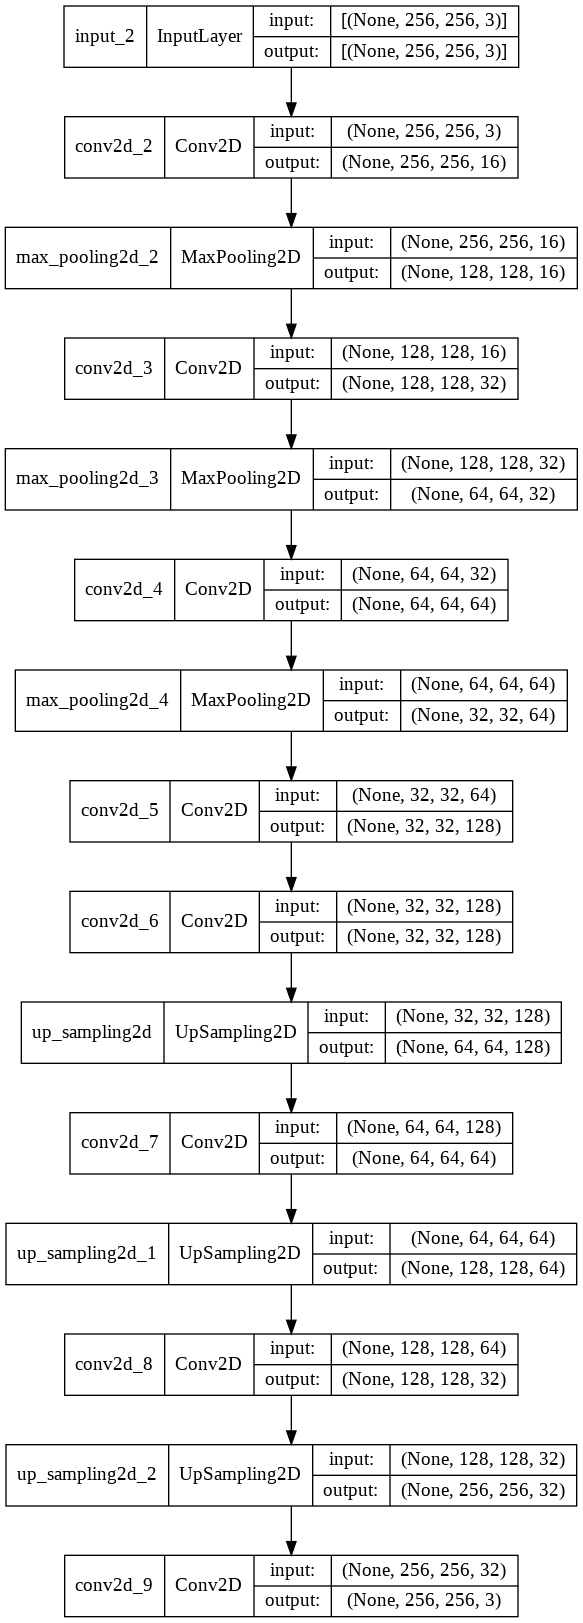

In [5]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='autoencoder_plot.png', show_shapes=True, show_layer_names=True)

Nous pouvons maintenant entraîner notre encodeur automatique en utilisant à la fois nos données d'entrée et notre cible.

Notre modéle est pret à etre entrainé : 

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Epoch 1/100
4/4 [==============================] - 9s 2s/step - loss: 0.0750 - accuracy: 0.3054 - val_loss: 0.0836 - val_accuracy: 0.4229
Epoch 2/100
4/4 [==============================] - 9s 2s/step - loss: 0.0712 - accuracy: 0.3056 - val_loss: 0.0707 - val_accuracy: 0.2362
Epoch 3/100
4/4 [==============================] - 9s 2s/step - loss: 0.0540 - accuracy: 0.3639 - val_loss: 0.0450 - val_accuracy: 0.4250
Epoch 4/100
4/4 [==============================] - 9s 2s/step - loss: 0.0392 - accuracy: 0.4083 - val_loss: 0.0371 - val_accuracy: 0.2859
Epoch 5/100
4/4 [==============================] - 9s 2s/step - loss: 0.0331 - accuracy: 0.2727 - val_loss: 0.0313 - val_accuracy: 0.4344
Epoch 6/100
4/4 [==============================] - 9s 2s/step - loss: 0.0291 - accuracy: 0.4545 - val_loss: 0.0306 - val_accuracy: 0.4901
Epoch 7/100
4/4 [==============================] - 9s 2s/step - loss: 0.0271 - accuracy: 0.3421 - val_loss: 0.0266 - val_accuracy: 0.3917
Epoch 8/100
4/4 [=================

Les lignes précédentes montrent les valeurs de perte pendant l'entraînement.


In [ ]:
# load model
autoencoder = keras.models.load_model("denoiser_modal128.h5")
out = autoencoder.predict(x_test_noisy, verbose=1)

### Visualisation des résultats de l'apprentissage

Comparons les images de base aux images reconstruites à l'aide des photos bruités.

1/1 [==============================] - 0s 395ms/step


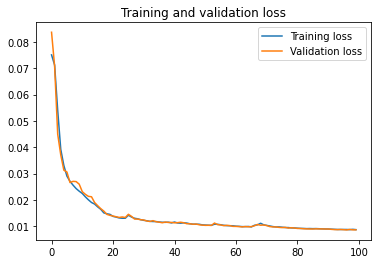

Text(0.5, 1.0, 'Training and Validation Accuracy')

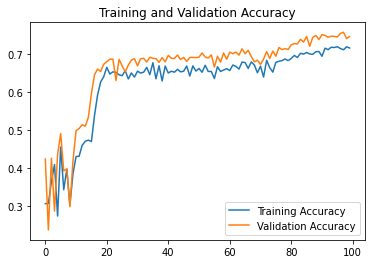

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Nous pouvons observer sur le graph ci-dessus l'evolution du "loss" en fonction des "epochs". Plus le modele apprend, moins la perte de precision est grande. Ce qui nous améne au résultat suivant, des images presque totalement débruitées :

Images de test


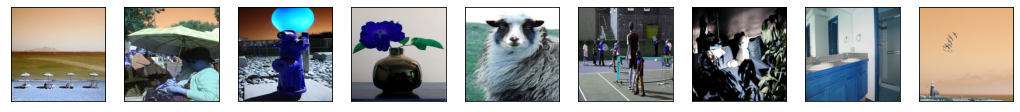

Images de test aprés avoir appliqué le bruit


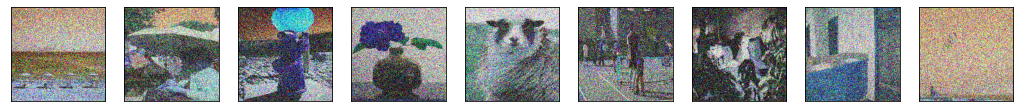

Images de test debruitées


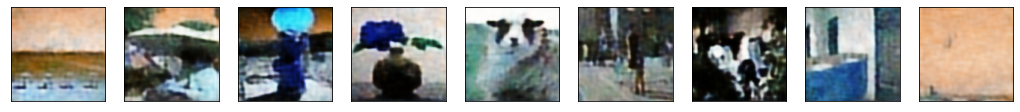

In [ ]:
print("Images de test")
printImg(x_test, 10)
print("Images de test aprés avoir appliqué le bruit")
printImg(x_test_noisy, 10)
print("Images de test debruitées")
printImg(out, 10)

Remarquez à quel point les prédictions sont assez proches des images originales, bien que pas tout à fait les mêmes. Nous remarquons que les images reconstruites ont perdu en qualité mais que la majorité du bruit à été supprimé, les couleurs sont présentes et la plupart des détails aussi. Ce modèle est donc valide.

In [ ]:
# Save our model
autoencoder.save("denoiser_modal128.h5")

## 6. Conclusion & Amélioration

Nous avons déduit que le modèle d'auto-encodeur se basant sur la convolution était le plus performant pour nos données, en effet, le mécanisme de la convolution est adapté pour travailler sur des matrices.

## 7. Références

- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html) 
- [Auto-Encoder: What Is It? And What Is It Used For?](https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726)
- [Les Autoencoders – modèles d’apprentissage non supervisé](https://datascientest.com/les-autoencoders-modeles-dapprentissage-non-supervise)
- [AUTO-ENCODEUR](https://dataanalyticspost.com/Lexique/auto-encodeur/#:~:text=Auto%2Dencodeur%20%3A%20Les%20auto%2D,d'un%20jeu%20de%20donn%C3%A9es.&text=L'architecture%20la%20plus%20simple,semblable%20%C3%A0%20un%20perceptron%20multicouches.)
- [Comment fonctionnent les auto-encodeurs?](https://fr.acervolima.com/comment-fonctionnent-les-auto-encodeurs/)